In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9ozend8d because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


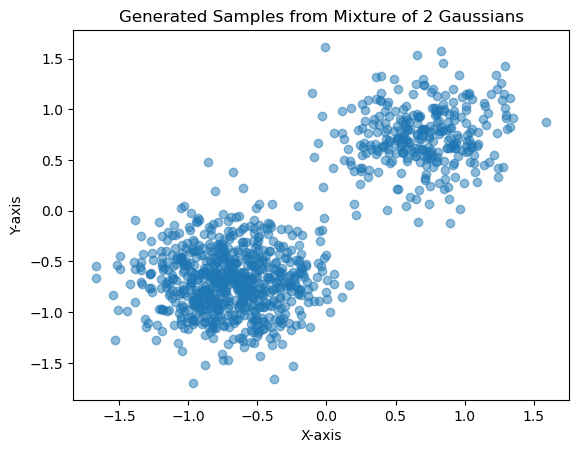

In [2]:
# Chat GPT generated code to sample from mixture of 2 2-dimensional Gaussians

# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-.7, -.7])
covariance1 = np.array([[.1, 0.], [0., .1]])
precision1 = inv(covariance1)
weight1 = .7

mean2 = np.array([.7, .7])
covariance2 = np.array([[.1, 0.], [0., .1]])
precision2 = inv(covariance2)
weight2 = .3

# Generate synthetic data
num_samples = 1000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]
generated_samples = generate_samples(num_samples, means, covariances, weights)

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [4]:
# problem dimension
d = 2

# neural net dimension
h1 = 4
h2 = 8
h3 = 4

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h1, d], [h1], [h2, h1], [h2], [h3, h2], [h3], [d, h3], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2, W3, b3, W4, b4 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W2, h) + b2)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W3, h) + b3)
    
    # output
    z = jnp.einsum('ij,...j->...i', W4, h) + b4
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

# @jit 
# def inv_nn(z, lmbda):
    
#     # weights and biases of nn
#     W1, b1, W3, b3 = reshape(lmbda)
    
#     # hidden layer
#     h = jnp.einsum('ij,...j->...i', inv(W3), z - b3)
    
#     # input 
#     # h = jnp.einsum('ij,...j->...i', inv(W2), jnp.arctanh(h) - b2)
    
#     # input 
#     y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

#     return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
# jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [5]:
# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    # l1 = weight1 * N(zi | m1, C1)
    # l2 = weight2 * N(zi | m2, C2)
    l1 = weight1 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance1))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean1, precision1, zi-mean1) / 2.)
    l2 = weight2 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance2))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean2, precision2, zi-mean2) / 2.)
    return -jnp.log(l1 + l2)
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [6]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=10000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=10)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [7]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 9.747
KL 8.635
KL 8.054
KL 7.524
KL 6.894
KL 6.532
KL 6.005
KL 5.599
KL 5.314
KL 5.071
KL 4.785
KL 4.592
KL 4.284
KL 4.223
KL 4.296
KL 3.972
KL 3.832
KL 3.934
KL 3.734
KL 3.573
KL 3.787
KL 3.726
KL 3.684
KL 3.541
KL 3.565
KL 3.508
KL 3.520
KL 3.659
KL 3.589
KL 3.474
KL 3.548
KL 3.536
KL 3.363
KL 3.310
KL 3.381
KL 3.426
KL 3.337
KL 3.482
KL 3.401
KL 3.475
KL 3.581
KL 3.295
KL 3.363
KL 3.178
KL 3.453
KL 3.346
KL 3.629
KL 3.233
KL 3.428
KL 3.190
KL 3.244
KL 3.355
KL 3.471
KL 3.281
KL 3.253
KL 3.440
KL 3.105
KL 3.417
KL 3.362
KL 3.484
KL 3.383
KL 3.246
KL 3.436
KL 3.428
KL 3.423
KL 3.386
KL 3.299
KL 3.114
KL 3.429
KL 3.211
KL 3.417
KL 3.438
KL 3.184
KL 3.270
KL 3.519
KL 2.962
KL 3.511
KL 3.218
KL 3.340
KL 3.144
KL 3.398
KL 3.370
KL 3.400
KL 3.390
KL 3.389
KL 3.595
KL 3.581
KL 3.422
KL 3.498
KL 3.216
KL 3.087
KL 3.346
KL 3.166
KL 3.298
KL 3.422
KL 3.408
KL 3.043
KL 3.325
KL 3.159
KL 3.231
KL 3.328
KL 3.333
KL 3.176
KL 3.479
KL 3.386
KL 3.141
KL 3.403
KL 3.232
KL 3.245
KL 3.148
KL 3.291
K

KL 2.898
KL 2.868
KL 2.855
KL 2.990
KL 2.835
KL 2.955
KL 2.837
KL 2.987
KL 2.883
KL 2.906
KL 2.905
KL 2.785
KL 3.003
KL 2.729
KL 2.832
KL 3.154
KL 3.005
KL 3.048
KL 2.972
KL 2.888
KL 2.753
KL 2.995
KL 2.843
KL 2.872
KL 2.947
KL 3.019
KL 2.936
KL 2.854
KL 2.911
KL 2.762
KL 2.969
KL 2.842
KL 2.792
KL 3.033
KL 2.880
KL 2.830
KL 2.779
KL 2.925
KL 2.913
KL 2.969
KL 3.149
KL 2.801
KL 2.963
KL 2.875
KL 2.905
KL 2.967
KL 2.869
KL 2.943
KL 2.917
KL 2.865
KL 2.985
KL 2.776
KL 2.874
KL 2.677
KL 2.937
KL 2.839
KL 2.799
KL 2.998
KL 3.066
KL 2.907
KL 2.968
KL 2.889
KL 3.073
KL 2.807
KL 2.888
KL 2.962
KL 2.928
KL 2.925
KL 2.833
KL 3.118
KL 2.734
KL 2.890
KL 2.978
KL 2.903
KL 2.978
KL 3.016
KL 3.051
KL 2.843
KL 2.963
KL 2.818
KL 3.082
KL 3.110
KL 2.871
KL 2.896
KL 3.018


In [8]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

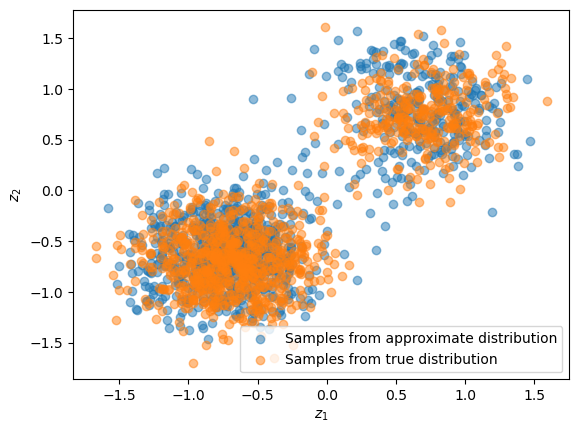

In [9]:
plt.scatter(z[:, 0], z[:, 1], alpha=.5, label='Samples from approximate distribution')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label="Samples from true distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.legend()
plt.show()